In [1]:
#importing the dependencies
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import ensemble
import time
import numpy as np
from sklearn.svm import SVC
import pandas as pd
from collections import Counter
import imblearn
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB,MultinomialNB,_BaseNB
import seaborn as sn

In [2]:
#faster training
from sklearnex import patch_sklearn
patch_sklearn()
#10 to 100x fast

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
#Load the data
lfw=datasets.fetch_lfw_people(min_faces_per_person=100,resize=0.5)

In [4]:
lfw.keys()

dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])

In [5]:
lfw.data.shape

(1140, 2914)

In [6]:
lfw.images.shape
imtotal,imx,imy=lfw.images.shape
print(imtotal,imx,imy)

1140 62 47


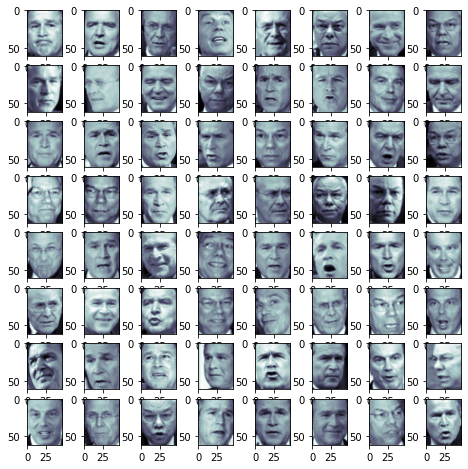

In [7]:
#plot the figures
fig=plt.figure(figsize=(8,8))
for i in range(64):
    ax=fig.add_subplot(8,8,i+1)
    ax.imshow(lfw.images[i],cmap=plt.cm.bone) 

In [8]:
x,y=lfw.data,lfw.target

In [9]:
print(imblearn.__version__)

0.7.0


In [10]:
#split the data for training and testing
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=0)

In [11]:
x_train.shape,x_test.shape,x.shape

((855, 2914), (285, 2914), (1140, 2914))

In [12]:
#PCA instance for checking how many features to take 
pca_check=PCA()
pca_check.fit(x_train)

PCA()

In [13]:
#check upto how many features a defined explained variance is reached
k=0
currsum=0
while currsum<0.90:  #for 90%
    currsum+=pca_check.explained_variance_ratio_[k]
    k+=1
k

78

In [14]:
#make pca instance with k components
pca_lwf=PCA(n_components=k,whiten=True)
#whiten does normalization (removes the relative variance scales of the components)
#Accuracy Score : 91.22% -> 91.57% by using whiten=True (SVC with PCA score)

In [15]:
x_train.shape

(855, 2914)

## Grid Search CV to tune parameters of algorithms

In [16]:
#Uncommment to do search

clf=ensemble.RandomForestClassifier()
grid={"max_leaf_nodes":list(np.arange(60,100))}
gscv=GridSearchCV(clf,grid)
gscv.fit(x_train,y_train)
gscv.best_estimator_

#max leaf nodes = 114

In [17]:
# gscv.best_score_

In [18]:
# gscv.cv_results_

In [19]:
#Uncommment to do search

clf=SVC()
grid={"gamma":[0.00001,1,100000],"C":[0.00001,1,100000]}
gscv_svc=GridSearchCV(clf,grid)
gscv_svc.fit(x_train,y_train)
gscv_svc.best_estimator_

#Basically no effect on score for gamma and C arount '1'

In [20]:
# gscv_svc.best_score_

In [21]:
# gscv_svc.cv_results_

### Perform Oversampling to balance input train data for different classes

In [22]:
#Print count of various y values
print(sorted(Counter(y).items() ))
print(sorted(Counter(y_train).items() ))
print(sorted(Counter(y_test).items() ))

[(0, 236), (1, 121), (2, 530), (3, 109), (4, 144)]
[(0, 175), (1, 85), (2, 408), (3, 78), (4, 109)]
[(0, 61), (1, 36), (2, 122), (3, 31), (4, 35)]


In [23]:
#oversampling the train data for every non majority class
oversample = imblearn.over_sampling.RandomOverSampler(sampling_strategy="not majority")
x_train,y_train=oversample.fit_resample(x_train,y_train)

print(sorted(Counter(y_train).items() ))

[(0, 408), (1, 408), (2, 408), (3, 408), (4, 408)]


In [24]:
#Apply PCA on oversampled data
x_transformed=pca_lwf.fit_transform(x_train)

In [25]:
pca_lwf.n_components

78

In [26]:
x_transformed.shape

(2040, 78)

### Visualize approx data of faces ( generated by PCA tranform )

In [27]:
x_approx=pca_lwf.inverse_transform(x_transformed)
x_approx=x_approx.reshape((len(x_train),imx,imy))

In [28]:
x_approx.shape

(2040, 62, 47)

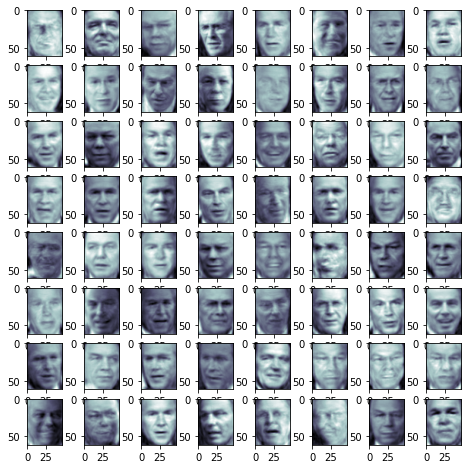

In [29]:
#Plot approx faces
fig=plt.figure(figsize=(8,8))
for i in range(64):
    ax=fig.add_subplot(8,8,i+1)
    plt.imshow(x_approx[i],cmap=plt.cm.bone)
plt.show()

### Visualize Eigenfaces/Eigenvectors

In [30]:
eigen=pca_lwf.components_
eigen_faces=eigen.reshape((eigen.shape[0],imx,imy))

In [31]:
eigen.shape

(78, 2914)

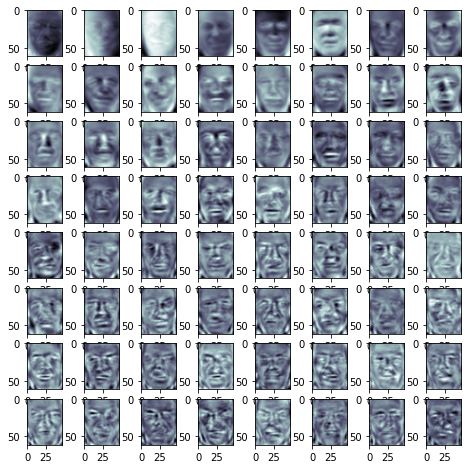

In [32]:
#Plot eigenfaces
fig=plt.figure(figsize=(8,8))
for i in range(64):
    ax=fig.add_subplot(8,8,i+1)
    plt.imshow(eigen_faces[i],cmap=plt.cm.bone)
plt.show()

In [33]:
#Renaming training data
x_train_pca=x_transformed
#Tranforming testing data
x_test_pca=pca_lwf.transform(x_test)
#stores scores of every algorithm
all_scores=[]

## Apply ML Algorithms

## Random Forest

Time taken =  0.20468878746032715
              precision    recall  f1-score   support

           0       0.80      0.79      0.79        61
           1       0.89      0.44      0.59        36
           2       0.70      0.96      0.81       122
           3       0.86      0.61      0.72        31
           4       0.78      0.40      0.53        35

    accuracy                           0.75       285
   macro avg       0.81      0.64      0.69       285
weighted avg       0.77      0.75      0.73       285



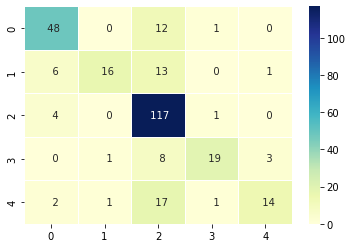

In [34]:
#without PCA 
rf=ensemble.RandomForestClassifier(max_leaf_nodes=114,random_state=0)
start=time.time()
rf.fit(x_train,y_train)
print("Time taken = ",time.time()-start)
y_pred=rf.predict(x_test)
print(classification_report(y_test,y_pred))
ax=sn.heatmap(confusion_matrix(y_test,y_pred),annot=True,linewidths=0.5,fmt="4",cmap="YlGnBu")

Time taken =  0.3150749206542969
              precision    recall  f1-score   support

           0       0.87      0.90      0.89        61
           1       0.86      0.50      0.63        36
           2       0.75      0.94      0.84       122
           3       0.84      0.52      0.64        31
           4       0.79      0.66      0.72        35

    accuracy                           0.80       285
   macro avg       0.82      0.70      0.74       285
weighted avg       0.81      0.80      0.79       285



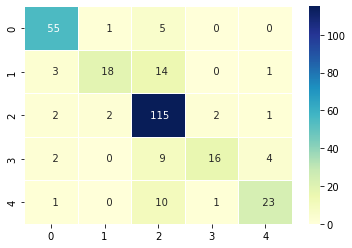

In [35]:
#with PCA
rf_pca=ensemble.RandomForestClassifier(max_leaf_nodes=114,random_state=0)
start=time.time()
rf_pca.fit(x_train_pca,y_train)
print("Time taken = ",time.time()-start)
y_pred=rf_pca.predict(x_test_pca)
print(classification_report(y_test,y_pred))
ax=sn.heatmap(confusion_matrix(y_test,y_pred),annot=True,linewidths=0.5,fmt="4",cmap="YlGnBu")

In [36]:
print(rf_pca.score(x_train_pca,y_train),rf_pca.score(x_test_pca,y_test))

non_pca_score=rf.score(x_test,y_test)
pca_score=rf_pca.score(x_test_pca,y_test)
all_scores.append(["Random Forest :",non_pca_score,pca_score])

print(non_pca_score,pca_score)

1.0 0.7964912280701755
0.7508771929824561 0.7964912280701755


## SVC


Time taken =  1.7238645553588867
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        61
           1       0.90      0.78      0.84        36
           2       0.88      0.98      0.93       122
           3       0.89      0.77      0.83        31
           4       0.90      0.80      0.85        35

    accuracy                           0.90       285
   macro avg       0.90      0.85      0.87       285
weighted avg       0.90      0.90      0.90       285



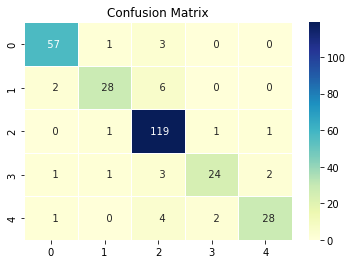

In [37]:
#without PCA
svc=SVC()
start=time.time()
svc.fit(x_train,y_train)
print("Time taken = ",time.time()-start)
y_pred=svc.predict(x_test)
print(classification_report(y_test,y_pred))
plt.title("Confusion Matrix")
ax=sn.heatmap(confusion_matrix(y_test,y_pred),annot=True,linewidths=0.5,fmt="4",cmap="YlGnBu")

In [38]:
print(svc.score(x_train,y_train),svc.score(x_test,y_test))

0.9955882352941177 0.8982456140350877


Time taken =  0.09831023216247559
              precision    recall  f1-score   support

           0       0.94      0.95      0.94        61
           1       0.94      0.81      0.87        36
           2       0.89      0.98      0.93       122
           3       0.96      0.84      0.90        31
           4       0.94      0.86      0.90        35

    accuracy                           0.92       285
   macro avg       0.93      0.89      0.91       285
weighted avg       0.92      0.92      0.92       285



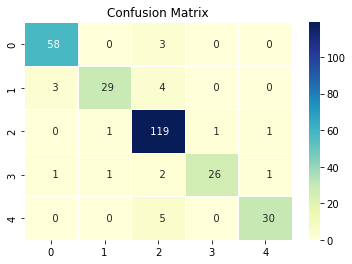

In [39]:
#with PCA
svc_pca=SVC()
start=time.time()
svc_pca.fit(x_train_pca,y_train)
print("Time taken = ",time.time()-start)
y_pred=svc_pca.predict(x_test_pca)
print(classification_report(y_test,y_pred))
plt.title("Confusion Matrix")
ax=sn.heatmap(confusion_matrix(y_test,y_pred),annot=True,linewidths=0.5,fmt="4",cmap="YlGnBu")

In [40]:
print(svc_pca.score(x_train_pca,y_train),svc_pca.score(x_test_pca,y_test))

non_pca_score=svc.score(x_test,y_test)
pca_score=svc_pca.score(x_test_pca,y_test)
all_scores.append(["Support Vector Classifier :",non_pca_score,pca_score])

print(non_pca_score,pca_score)

0.9980392156862745 0.9192982456140351
0.8982456140350877 0.9192982456140351


## Logistic Regression

Time taken =  0.6130986213684082
              precision    recall  f1-score   support

           0       0.83      0.87      0.85        61
           1       0.82      0.78      0.80        36
           2       0.88      0.93      0.90       122
           3       0.92      0.74      0.82        31
           4       0.91      0.86      0.88        35

    accuracy                           0.87       285
   macro avg       0.87      0.83      0.85       285
weighted avg       0.87      0.87      0.87       285



c:\Users\Dell\anaconda3\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:459: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


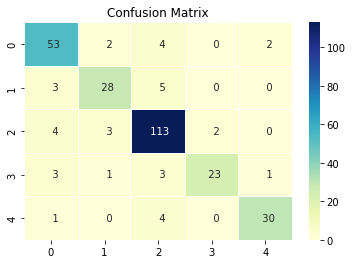

In [41]:
#without PCA
lr=LogisticRegression()
start=time.time()
lr.fit(x_train,y_train)
print("Time taken = ",time.time()-start)
y_pred=lr.predict(x_test)
print(classification_report(y_test,y_pred))
plt.title("Confusion Matrix")
ax=sn.heatmap(confusion_matrix(y_test,y_pred),annot=True,linewidths=0.5,fmt="4",cmap="YlGnBu")

Time taken =  0.014599800109863281
              precision    recall  f1-score   support

           0       0.84      0.89      0.86        61
           1       0.85      0.78      0.81        36
           2       0.92      0.90      0.91       122
           3       0.72      0.74      0.73        31
           4       0.84      0.89      0.86        35

    accuracy                           0.86       285
   macro avg       0.83      0.84      0.84       285
weighted avg       0.86      0.86      0.86       285



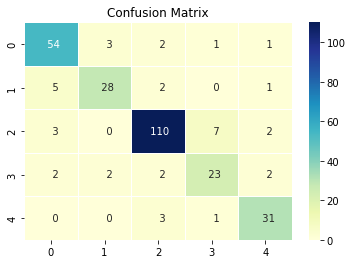

In [42]:
#with PCA
lr_pca=LogisticRegression()
start=time.time()
lr_pca.fit(x_train_pca,y_train)
print("Time taken = ",time.time()-start)
y_pred=lr_pca.predict(x_test_pca)
print(classification_report(y_test,y_pred))
plt.title("Confusion Matrix")
ax=sn.heatmap(confusion_matrix(y_test,y_pred),annot=True,linewidths=0.5,fmt="4",cmap="YlGnBu")

In [43]:
print(lr_pca.score(x_train_pca,y_train),lr_pca.score(x_test_pca,y_test))

non_pca_score=lr.score(x_test,y_test)
pca_score=lr_pca.score(x_test_pca,y_test)
all_scores.append(["Logistic Regression :",non_pca_score,pca_score])

print(non_pca_score,pca_score)

0.9700980392156863 0.8631578947368421
0.8666666666666667 0.8631578947368421


## Naive Bayes

Time taken =  0.03795981407165527
              precision    recall  f1-score   support

           0       0.44      0.61      0.51        61
           1       0.57      0.58      0.58        36
           2       0.82      0.61      0.70       122
           3       0.29      0.39      0.33        31
           4       0.67      0.57      0.62        35

    accuracy                           0.58       285
   macro avg       0.56      0.55      0.55       285
weighted avg       0.63      0.58      0.59       285



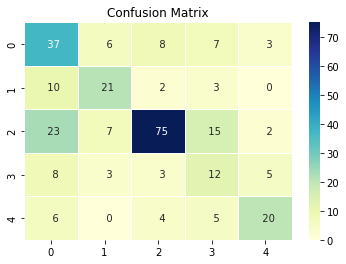

In [44]:
#without PCA
gnb=GaussianNB()
start=time.time()
gnb.fit(x_train,y_train)
print("Time taken = ",time.time()-start)
y_pred=gnb.predict(x_test)
print(classification_report(y_test,y_pred))
plt.title("Confusion Matrix")
ax=sn.heatmap(confusion_matrix(y_test,y_pred),annot=True,linewidths=0.5,fmt="4",cmap="YlGnBu")


Time taken =  0.0019426345825195312
              precision    recall  f1-score   support

           0       0.84      0.93      0.88        61
           1       0.81      0.72      0.76        36
           2       0.91      0.89      0.90       122
           3       0.69      0.71      0.70        31
           4       0.76      0.74      0.75        35

    accuracy                           0.84       285
   macro avg       0.80      0.80      0.80       285
weighted avg       0.84      0.84      0.84       285



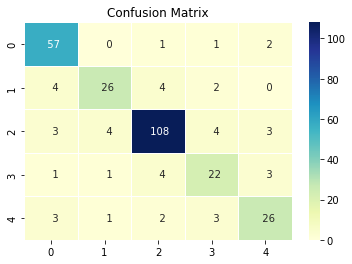

In [45]:
#with PCA
gnb_pca=GaussianNB()
start=time.time()
gnb_pca.fit(x_train_pca,y_train)
print("Time taken = ",time.time()-start)
y_pred=gnb_pca.predict(x_test_pca)
print(classification_report(y_test,y_pred))
plt.title("Confusion Matrix")
ax=sn.heatmap(confusion_matrix(y_test,y_pred),annot=True,linewidths=0.5,fmt="4",cmap="YlGnBu")


In [46]:
print(gnb_pca.score(x_train_pca,y_train),gnb_pca.score(x_test_pca,y_test))

non_pca_score=gnb.score(x_test,y_test)
pca_score=gnb_pca.score(x_test_pca,y_test)
all_scores.append(["Gaussian Naive Bayes :",non_pca_score,pca_score])

print(non_pca_score,pca_score)

0.9009803921568628 0.8385964912280702
0.5789473684210527 0.8385964912280702


## Tabulate scores of all the algorithms

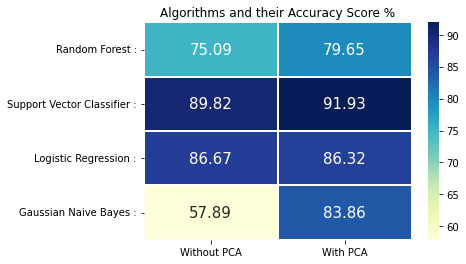

In [47]:
import copy
l=copy.deepcopy(all_scores)
data=np.array([rw[1:]for rw in l])*100
plt.title("Algorithms and their Accuracy Score %")
ax=sn.heatmap(data,annot=True,linewidths=1.7,fmt="4.4",cmap="YlGnBu",xticklabels=["Without PCA","With PCA"],yticklabels=list([rw[0] for rw in l]),annot_kws={'size':15})